In [85]:
import sys
sys.path.append('C:\\Users\\mohini\\Documents\\LoadModelingAndAgg\\pecan_street\\PecanPy\\examples')

import datetime as dat
from datetime import timezone
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pecanpy
import scipy.stats as stats
import scipy as sp
import itertools
import numpy.random as random

import configparser as cp

%matplotlib inline
plt.style.use("ggplot")

In [101]:
# Get access credentials
config = cp.ConfigParser();
config.read('setup.ini')

# define user credentials
USER_NAME = str(config['DEFAULT']['username']);
PASSWORD = str(config['DEFAULT']['password']);

# define db server params
SCHEMA = 'university'
HOST = 'dataport.cloud'
PORT = '5434'
DB = 'postgres'

# create the engine that connects to the database...
engine = pecanpy.create_engine(USER_NAME, PASSWORD, HOST, PORT, DB)

In [102]:
with engine.connect() as con:
    metadata_df = pecanpy.read_metadata_table(con, schema=SCHEMA)
[nHomes, nAttribs] = metadata_df.shape
print("Number of homes: " + str(nHomes))

Number of homes: 1460


In [4]:
with_egauge_data = metadata_df[metadata_df.egauge_min_time.notnull()]

In [5]:
start_time = dat.datetime(2016,6,1,0,0, tzinfo=timezone.utc)
end_time = dat.datetime(2016,6,30,0,0, tzinfo=timezone.utc)
with_times = metadata_df[metadata_df.egauge_min_time < start_time]
with_times = with_times[with_times.egauge_max_time > end_time]
print(with_times.shape)

(428, 108)


## Aggregate Analysis Functions
The following function computes different statistics for load data at different aggregation levels. It takes in a matrix of raw load data consisting of N homes with T load measurements. Then, based on the other arguments, these load profiles are sampled and aggregated to generate statistics of interest. 

In [82]:
def aggLoadStats(loadMat, aggLevels, statList, samplesPerLevel=100):
# loadMat : [NxT] Matrix of load measurements for N customers at T time points. 
# aggLevels: [A] Array of A aggregation levels. max(A) <= N
# statList: [length S list of functions]. Statistics to be computed on the aggregate load curves. 
# Every function in the list should take a (MxT) matrix argument where M is the number of chosen loads. 
# samplesPerLevel: For N total customers and an aggregation level of k, we have
# N choose k possibilities. This might be too large a number to compute, so we limit
# the maximum number of aggregate samples we take at a given aggregation level. 
    [N, T] = np.shape(loadMat);
    
    # Check
    if max(aggLevels) > N:
        print("Warning: The highest level of aggregation is greater than available loads.")
    
    nAggLevels = np.size(aggLevels);
    numStats = len(statList); 
    
    # Set up the matrix for gathering results. 
    loadStats = np.nan*np.ones([nAggLevels, samplesPerLevel, numStats]);
    
    for i in range(nAggLevels): 
        m = aggLevels[i];
        # Total number of possible combinations
        Nchoosem = int(sp.special.comb(N, m))
        
        if Nchoosem < samplesPerLevel:
            # Iterate through all possible combinations
            allCombs = itertools.combinations(np.arange(N), m)
            j = 0;
            for chosen in allCombs:
                chosenLoad = loadMat[chosen, :];
                # Compute and save all statistics
                for k in range(numStats):
                    statFunc = statList[k];
                    loadStats[i, j, k] = statFunc(chosenLoad);
                j = j + 1;
        else:
            # Generate "samplesPerLevel" of random combinations
            for j in range(samplesPerLevel):
                chosen = random.choice(N, size=m, replace=False);
                chosenLoad = loadMat[chosen, :]
                # Compute and save all statistics
                for k in range(numStats):
                    statFunc = statList[k];
                    loadStats[i, j, k] = statFunc(chosenLoad);
                    #print(i); print(j); print(k);
                    #print(statFunc(chosenLoad));
                    
    return loadStats
    
###################################################################
# Statistics we wish to compute on aggregate load
# All these functions take an MxT matrix argument where 
# M = number of loads (some subset of all loads)
# T = number of measurement time points. 
###################################################################

def meanTotalLoad(load):
    return np.mean(np.sum(load, axis=0));

def varTotalLoad(load):
    return np.var(np.sum(load, axis=0));
                
def loadFactor(load):
    totalLoad = np.sum(load, axis=0);
    maxLoad = np.max(totalLoad);
    meanLoad = np.mean(totalLoad);
    return maxLoad / meanLoad

def cvLoad(load):
    totalLoad = np.sum(load, axis=0);
    meanLoad = np.mean(totalLoad);
    sigLoad = np.sqrt(np.var(totalLoad));
    return sigLoad / meanLoad

# This function aims to give us a sense of the predictability of the
# load as aggregation increases. 
def maxHourlyVar(load):
    hourlyVar = np.var(load, axis=0)

# Experiment 1
## Variance of load over time vs. aggregation level

In [21]:
def getAggLoad(homes, start_time, end_time, rez='H'):
    dataCount = 0
    for home in homes:
        with engine.connect() as con:
            # Query data
            homeload = pecanpy.read_electricity_egauge_query(con, SCHEMA, home, start_time, end_time, "all", rez)
            load = homeload['use']
            bad = load.isnull().values.any() or load.empty
            if not bad:
                if dataCount==0:
                    totalLoad = load
                else:
                    totalLoad = totalLoad + load
                dataCount = dataCount + 1;
    return totalLoad, dataCount

def getNLoads(N, homes, start_time, end_time, rez='H'):
    dataCount = 0;
    idx = 0;
    numHomes = np.size(homes)
    while dataCount < N and idx < numHomes:
        with engine.connect() as con:
            home = homes[idx]
            homeload = pecanpy.read_electricity_egauge_query(con, SCHEMA, home, start_time, end_time, "all", rez)
            load = homeload['use']
            bad = load.isnull().values.any() or load.empty
            if not bad:
                if dataCount==0:
                    allLoads = load
                else:
                    allLoads = pd.concat([allLoads, load], axis=1)
                dataCount = dataCount + 1
            idx = idx + 1;
    return allLoads 

Text(0.5,1,'Aggregate load for 10 homes over 29 days.')

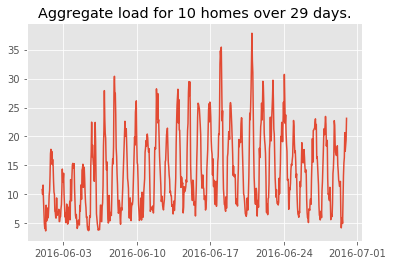

In [77]:
nAgg = 10
homes = with_times.sample(n=nAgg)
homes = homes.index

# Choose starting time and ending time
start_time = dat.datetime(2016,6,1,0,0, tzinfo=timezone.utc)
end_time = dat.datetime(2016,6,30,0,0, tzinfo=timezone.utc)
days = (end_time - start_time).days

# Get 1 hour resolution data for the homes
totalLoad, c = getAggLoad(homes, start_time, end_time)
plt.plot(totalLoad); plt.title('Aggregate load for ' + str(nAgg) + ' homes over ' + str(days) + ' days.')

In [135]:
start_time = dat.datetime(2016,6,1,0,0, tzinfo=timezone.utc)
end_time = dat.datetime(2016,6,2,0,0, tzinfo=timezone.utc)
N = 20; 

loads_20_df = getNLoads(N, with_times.index, start_time, end_time, rez='T')

In [23]:
start_time = dat.datetime(2016,6,1,0,0, tzinfo=timezone.utc)
end_time = dat.datetime(2016,6,30,0,0, tzinfo=timezone.utc)
N = 20; 

hourlyloads_20_df = getNLoads(N, with_times.index, start_time, end_time, rez='H')

## More extensive aggregate statistics tests
August 25, 2018

In [83]:
loadMat = hourlyloads_20_df.values.T;
aggLevels = np.arange(1, 16);
statList = [meanTotalLoad, varTotalLoad, loadFactor, cvLoad];
R = aggLoadStats(loadMat, aggLevels, statList, samplesPerLevel=100)
# R has dimensions len(aggLevels) x samplesPerLevel x len(statList)

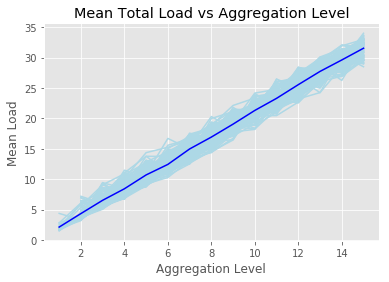

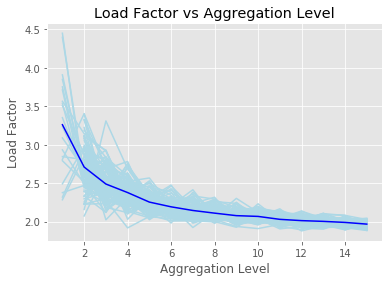

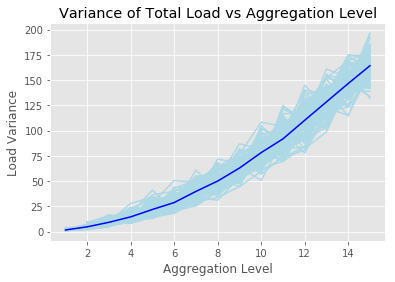

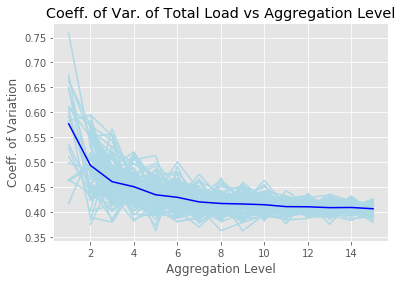

In [84]:
# Plot mean load vs aggregation
idx = 0;
plt.figure(); plt.plot(aggLevels, R[:, :, idx], color='lightblue');
plt.plot(aggLevels, np.nanmean(R[:, :, idx], axis=1), color='blue')
plt.xlabel('Aggregation Level'); plt.ylabel('Mean Load');
plt.title('Mean Total Load vs Aggregation Level');

# Plot load factor vs aggregation
idx = 2;
plt.figure(); plt.plot(aggLevels, R[:, :, idx], color='lightblue');
plt.plot(aggLevels, np.nanmean(R[:, :, idx], axis=1), color='blue')
plt.xlabel('Aggregation Level'); plt.ylabel('Load Factor');
plt.title('Load Factor vs Aggregation Level');

# Plot total variance of the load (over the full time series) vs aggregation
idx = 1;
plt.figure(); plt.plot(aggLevels, R[:, :, idx], color='lightblue');
plt.plot(aggLevels, np.nanmean(R[:, :, idx], axis=1), color='blue');
plt.xlabel('Aggregation Level'); plt.ylabel('Load Variance'); 
plt.title('Variance of Total Load vs Aggregation Level');

# Plot coeff of var of total load vs aggregation
idx = 3;
plt.figure(); plt.plot(aggLevels, R[:, :, idx], color='lightblue');
plt.plot(aggLevels, np.nanmean(R[:, :, idx], axis=1), color='blue');
plt.xlabel('Aggregation Level'); plt.ylabel('Coeff. of Variation'); 
plt.title('Coeff. of Var. of Total Load vs Aggregation Level');

## To Do: 

1. Box and whisker plots of statistics. 
2. Generalized load factor. x-axis is percentile. Multiple lines for different aggregation levels. 